In this project, I will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. I will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.

In [1]:
!pip3 install datasets skorch pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 79.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of torchdata to determine which version is compatible wit

#Imports

In [2]:
import torch
from torch import nn
from torch.nn import Embedding, RNN, LSTM, GRU, Linear, Transformer
import torch.nn.functional as F
from torchinfo import summary
from torchtext.datasets import IMDB
from torch.utils.data import DataLoader, Dataset, random_split
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchvision.transforms import Lambda
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
rng = np.random.default_rng(seed=4242)

#Data Loading and Preprocessing

In [3]:
train, test = IMDB(root="dataset", split=('train', 'test'))
Tr, Ts = list(train), list(test)
rng.shuffle(Tr)
rng.shuffle(Ts)
len_train, len_val, len_test = 25000, 12500, 12500 # Whole data
train_data, val_data, test_data = Tr[:len_train], Ts[:len_val], Ts[len_val:len_val+len_test]

In [4]:
len(train_data), len(val_data), len(test_data)

(25000, 12500, 12500)

In [5]:
idx = 10
label_samp, text_samp = train_data[idx]
print(f"text: {text_samp}")
print(f"label: {label_samp}")

text: Assuming this won't end up a straight-to-video release, I would have to say void this title at all costs. Unless you're bored of good, well-executed movies, that is. I saw this last night at AFI Dallas, and I left with 20 minutes remaining, simply because I didn't care anymore (about the plot, not about insulting the director...that is awkward). When you can spot a goof only 5 minutes into the movie (a shot out, shattered window before any shots are fired...and then the window breaks with the first shot), things are going to bad. Let's just say this is only an indicator of things to come...unfortunately.<br /><br />I'll spare you all the details, but this is sub-par in every manner, even the half-assed acting by Michael Madsen is disappointing when you're expecting half-assed acting from him. And the rape scene...Christ! "Shut up and take it" should never be used in a rape scene. EVER.<br /><br />3/10
label: 1


Let's check the dataset statistics.

In [6]:
datasets = {'train':train_data, 'val':val_data, 'test':test_data}
for key in datasets:
  label_dist = {}
  dataset = datasets[key]
  for lb, txt in dataset:
    if lb not in label_dist:
      label_dist.setdefault(lb, 1)
    else:
      label_dist[lb] += 1
  print(f"{key}:")
  print(label_dist)


train:
{1: 12500, 2: 12500}
val:
{2: 6245, 1: 6255}
test:
{2: 6255, 1: 6245}


In [7]:
tokenizer = get_tokenizer('basic_english')

def create_tokens(dataset):
  for sample in dataset:
    yield tokenizer(sample[1])

vocab = build_vocab_from_iterator(create_tokens(train_data), specials=["<oov>", "<sos>"], max_tokens=10000)
vocab.set_default_index(vocab["<oov>"])
print(f"Our vocabulary is made of {len(vocab)} tokens-index pairs.")

Our vocabulary is made of 10000 tokens-index pairs.


In [8]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [9]:
print(vocab.get_itos())  # top 10000 freq words (including special chars)

['<oov>', '<sos>', 'the', '.', ',', 'and', 'a', 'of', 'to', "'", 'is', 'it', 'in', 'i', 'this', 'that', 's', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', ')', '(', 'you', 't', 'on', 'not', 'he', 'are', 'his', 'have', 'be', 'one', '!', 'all', 'at', 'they', 'by', 'an', 'who', 'from', 'so', 'like', 'there', 'her', 'or', 'just', 'about', 'if', 'has', 'out', 'what', '?', 'some', 'good', 'can', 'more', 'when', 'she', 'very', 'even', 'my', 'no', 'up', 'would', 'time', 'which', 'only', 'story', 'really', 'their', 'see', 'had', 'we', 'were', 'me', 'than', 'well', 'much', '-', 'get', 'been', 'people', 'will', 'also', 'other', 'bad', 'into', 'do', 'because', 'great', 'first', 'how', 'him', 'don', 'most', 'its', 'made', 'then', 'them', 'way', 'could', 'make', 'too', 'any', 'after', 'movies', 'think', 'characters', 'character', 'watch', 'films', 'two', 'many', 'seen', 'being', 'never', 'little', 'plot', 'acting', 'where', 'best', 'love', 'did', 'life', 'show', 'know', 'does', 'ever', 'here',

In [10]:
word_index = {k:v for (k, v) in enumerate(vocab.get_itos())}

In [11]:
def decode_review(word_ids):
    return " ".join([word_index.get(word_id, "<err>") for word_id in word_ids])

print(text_samp)
print("\n")
print(decode_review(text_pipeline(text_samp)))

Assuming this won't end up a straight-to-video release, I would have to say void this title at all costs. Unless you're bored of good, well-executed movies, that is. I saw this last night at AFI Dallas, and I left with 20 minutes remaining, simply because I didn't care anymore (about the plot, not about insulting the director...that is awkward). When you can spot a goof only 5 minutes into the movie (a shot out, shattered window before any shots are fired...and then the window breaks with the first shot), things are going to bad. Let's just say this is only an indicator of things to come...unfortunately.<br /><br />I'll spare you all the details, but this is sub-par in every manner, even the half-assed acting by Michael Madsen is disappointing when you're expecting half-assed acting from him. And the rape scene...Christ! "Shut up and take it" should never be used in a rape scene. EVER.<br /><br />3/10


assuming this won ' t end up a straight-to-video release , i would have to say void

To keep the length of the all the input sequences same, I define the padding function. All the sentence less than the lenght of 500 will be padded with zeros and greater than 500 will be truncated. Notice that I will pad and truncate sequences right-wise, so that processing the sequences, the final hidden states of the recurrent networks will correspond to the final words of each sequence in the batch.



In [12]:
def sent_padding(sent_vec, maxlen):
  sent_vec = torch.tensor(sent_vec)
  maxlen -= len(sent_vec)
  return F.pad(sent_vec, (maxlen, 0))


print(sent_padding([1,2,3], maxlen=6))
print(sent_padding([1,2,3,4,5,6,7,8,9], maxlen=6))

tensor([0, 0, 0, 1, 2, 3])
tensor([4, 5, 6, 7, 8, 9])


In [13]:
seq_len = 500
sent_padding(text_pipeline(text_samp), maxlen=seq_len)

tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
class CustomDataset(Dataset):

  def __init__(self, dataset, seq_len=seq_len):
    super().__init__()
    self.dataset = dataset
    self.seq_len = seq_len

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    label, text = self.dataset[idx]
    label = label_pipeline(label)
    txt_rep = sent_padding(text_pipeline(text), maxlen=self.seq_len)
    label, txt_rep = torch.tensor(label, dtype=torch.float32), torch.tensor(txt_rep, dtype=torch.long)
    return label.to(device), txt_rep.to(device)

In [16]:
train_dataset = CustomDataset(train_data)
val_dataset = CustomDataset(val_data)
test_dataset = CustomDataset(test_data)

In [17]:
batch_size=256
dataloader_training = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_dataset, batch_size=batch_size)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size)

#Model Definition

- The first layer is an Embedding layer, with input_dim=vocab_dim and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [RNN]
- The output layer

### Model Comparison

In the next cell, I define simple RNN used for binary classification. The class has two main methods, the constructor (`init()`) and the `forward()` method.

In the constructor, the input parameters are used to define the layers and hyperparameters of the RNN. The layers that are defined include an embedding layer (`self.embedding`), a recurrent layer (`self.rnn`), and a linear layer (`self.linear`). The constructor also sets up various parameters such as the embedding input size, the embedding output size, the hidden size, the number of layers, the batch size, the RNN type, and whether or not the RNN is bidirectional.

The `forward()` method takes a batch of input data (`x`) and applies the layers defined in the constructor in a specific sequence. First, the input is passed through the embedding layer to create embeddings of the input tokens. These embeddings are then permuted to be of the correct shape for the RNN layer, which expects inputs of the form (`seq_len, batch_size, H_in`). The RNN layer is then applied to these embeddings, producing both the RNN output (`rnn_out`) and the last hidden state (`self.last_hidden`). Finally, the output of the RNN is passed through a linear layer and flattened to produce the final output of the network, which is a sigmoid activation function applied to a tensor of shape (`batch_size`). This output is then returned.

In [18]:
class My_RNN(nn.Module):
  def __init__(self, vocab_length, emb_dim, hidden_size, num_layers,
               batch_size, RNN_type, bidirectional, device=device):
    super().__init__()
    self.emb_in_dim = vocab_length  # 10000
    self.emb_out_dim = emb_dim  # 10
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.batch_size = batch_size
    self.RNN_type = RNN_type
    self.target_size = 1  # binary classification
    self.device = device
    self.D = 2 if self.bidirectional else 1  # enable/disable bidirectional

    valid_types = {'Simple RNN':RNN, 'LSTM':LSTM, 'GRU':GRU}
    assert self.RNN_type in valid_types.keys(), f'You must choose one of {valid_types.keys()} types'

    self.embedding = Embedding(self.emb_in_dim, self.emb_out_dim)

    chosen_rnn = valid_types[self.RNN_type]
    self.rnn = chosen_rnn(input_size=self.emb_out_dim, hidden_size=self.hidden_size,
                          num_layers=self.num_layers, bidirectional = self.bidirectional)

    self.linear = Linear(self.D*self.hidden_size, self.target_size)

  def forward(self, x):
    #x: (batch_size, 500)
    self.embeds = self.embedding(x)
    #embeds: (batch_size, 500, 10)
    #But rnn receives inputs of: (500, batch_size, 10) (seq_len, batch_size, H_in)
    self.embeds = self.embeds.permute(1, 0, 2)
    #embeds: (500, batch_size, 10) -> Now the shape is correct
    rnn_out, self.last_hidden = self.rnn(self.embeds)
    #rnn_out: (500, 256, 2*5:10) -> (seq_len, batch_size, D*hidden_size)
    #h_n: (1, 256, hidden_size) -> (D*num_layers, batch_size, hidden_size)
    output = self.linear(rnn_out[-1, :, :])
    #output: (256, 1) -> (batch_size, target_size)
    output = output.flatten()
    #output: (256) -> (batch_size)
    return F.sigmoid(output)

In [20]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'Simple RNN' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = False

EPOCHS = 10
lr = 1e-3

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [21]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [22]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 52.80%, Loss: 0.68967468 ---------------- Val_Acc: 55.06%, Val_Loss: 0.68499756
epoch: 2 -> Accuracy: 57.24%, Loss: 0.67451888 ---------------- Val_Acc: 58.85%, Val_Loss: 0.66760594
epoch: 3 -> Accuracy: 60.76%, Loss: 0.65658605 ---------------- Val_Acc: 61.75%, Val_Loss: 0.65138096
epoch: 4 -> Accuracy: 61.48%, Loss: 0.65174174 ---------------- Val_Acc: 60.25%, Val_Loss: 0.65894574
epoch: 5 -> Accuracy: 63.52%, Loss: 0.63349545 ---------------- Val_Acc: 64.82%, Val_Loss: 0.63101178
epoch: 6 -> Accuracy: 68.59%, Loss: 0.59249026 ---------------- Val_Acc: 67.78%, Val_Loss: 0.60402489
epoch: 7 -> Accuracy: 69.56%, Loss: 0.58199310 ---------------- Val_Acc: 64.46%, Val_Loss: 0.62450558
epoch: 8 -> Accuracy: 71.16%, Loss: 0.57268292 ---------------- Val_Acc: 69.29%, Val_Loss: 0.58884174
epoch: 9 -> Accuracy: 74.14%, Loss: 0.53186357 ---------------- Val_Acc: 70.73%, Val_Loss: 0.57515931
epoch: 10 -> Accuracy: 68.29%, Loss: 0.59221840 ---------------- Val_Acc: 61.22%, 

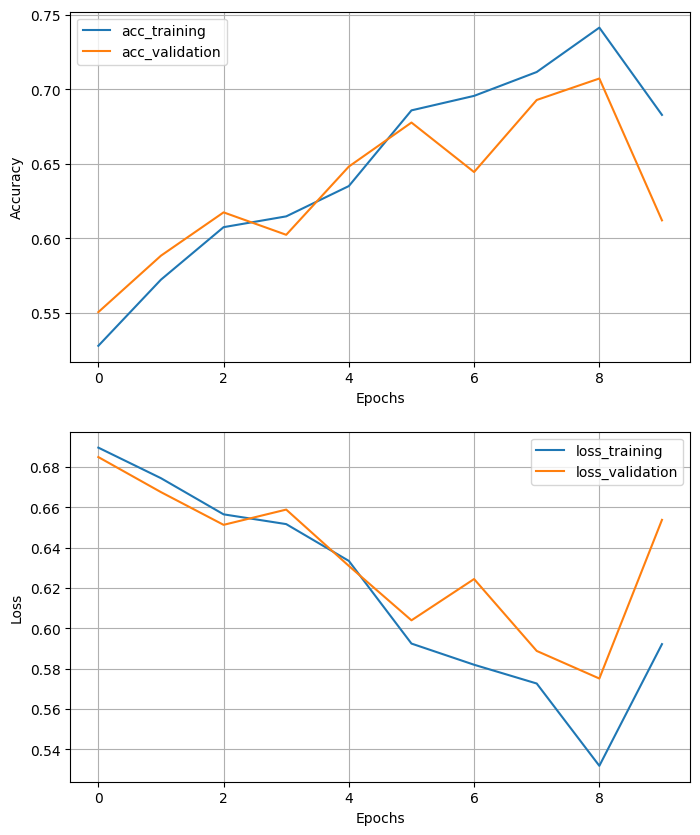

In [23]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(EPOCHS), acc_tr, label='acc_training')
    plt.plot(range(EPOCHS), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(EPOCHS), loss_tr, label='loss_training')
    plt.plot(range(EPOCHS), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [24]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")


In [25]:
test(model)

Test Loss: 0.65252697 ---------- Test Accuracy: 61.4000%


### LSTM

In [26]:
class My_LSTM(nn.Module):
    def __init__(self, vocab_length, emb_dim, hidden_size, num_layers,
                 batch_size, bidirectional, device=device):
        super().__init__()
        self.emb_in_dim = vocab_length
        self.emb_out_dim = emb_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.target_size = 1
        self.device = device
        self.D = 2 if self.bidirectional else 1

        self.embedding = nn.Embedding(self.emb_in_dim, self.emb_out_dim)

        self.lstm = nn.LSTM(input_size=self.emb_out_dim, hidden_size=self.hidden_size,
                            num_layers=self.num_layers, bidirectional=self.bidirectional)

        self.linear = nn.Linear(self.D*self.hidden_size, self.target_size)

    def forward(self, x):
        self.embeds = self.embedding(x)
        self.embeds = self.embeds.permute(1, 0, 2)
        lstm_out, (self.last_hidden, _) = self.lstm(self.embeds)
        output = self.linear(lstm_out[-1, :, :])
        output = output.flatten()
        return torch.sigmoid(output)

In [28]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'LSTM'
bidirectional = False

EPOCHS = 10
lr = 1e-3

model = My_LSTM(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [29]:
summary(model)

Layer (type:depth-idx)                   Param #
My_LSTM                                  --
├─Embedding: 1-1                         100,000
├─LSTM: 1-2                              5,632
├─Linear: 1-3                            33
Total params: 105,665
Trainable params: 105,665
Non-trainable params: 0

In [30]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):
      optimizer.zero_grad()
      logits = model(text)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val


In [31]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 52.71%, Loss: 0.69142342 ---------------- Val_Acc: 54.46%, Val_Loss: 0.68831384
epoch: 2 -> Accuracy: 55.88%, Loss: 0.68329346 ---------------- Val_Acc: 58.20%, Val_Loss: 0.67293370
epoch: 3 -> Accuracy: 59.23%, Loss: 0.68192136 ---------------- Val_Acc: 50.04%, Val_Loss: 0.79503340
epoch: 4 -> Accuracy: 55.40%, Loss: 0.69114405 ---------------- Val_Acc: 57.71%, Val_Loss: 0.67834342
epoch: 5 -> Accuracy: 60.10%, Loss: 0.66470134 ---------------- Val_Acc: 61.82%, Val_Loss: 0.65123361
epoch: 6 -> Accuracy: 63.43%, Loss: 0.64679509 ---------------- Val_Acc: 51.94%, Val_Loss: 0.70557511
epoch: 7 -> Accuracy: 64.06%, Loss: 0.64016455 ---------------- Val_Acc: 66.02%, Val_Loss: 0.62157732
epoch: 8 -> Accuracy: 69.84%, Loss: 0.58796269 ---------------- Val_Acc: 69.74%, Val_Loss: 0.58573341
epoch: 9 -> Accuracy: 71.74%, Loss: 0.56338841 ---------------- Val_Acc: 65.67%, Val_Loss: 0.64147675
epoch: 10 -> Accuracy: 66.06%, Loss: 0.65177035 ---------------- Val_Acc: 50.22%, 

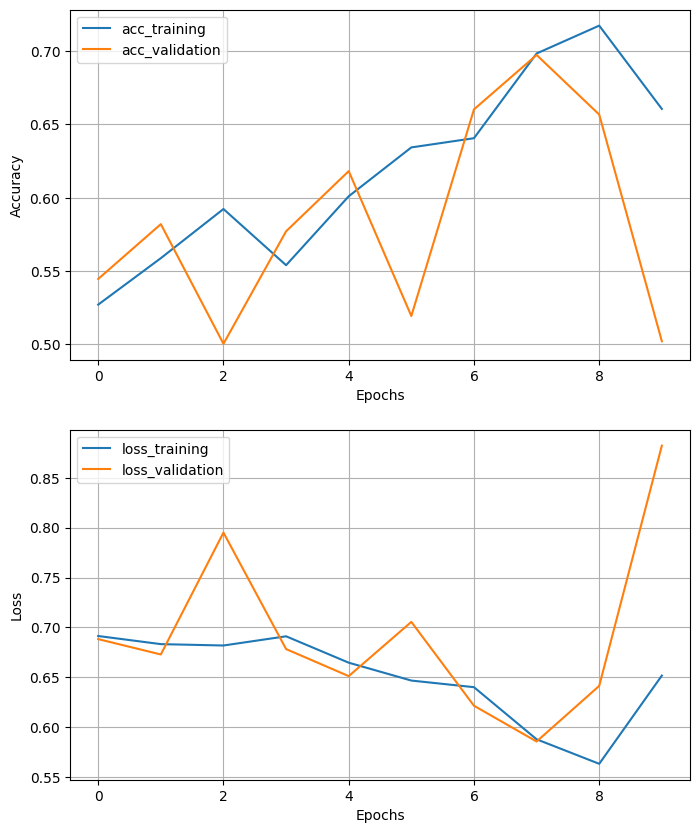

In [32]:
import matplotlib.pyplot as plt

def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):
    epochs = len(loss_tr)

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(epochs), acc_tr, label='acc_training')
    plt.plot(range(epochs), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(epochs), loss_tr, label='loss_training')
    plt.plot(range(epochs), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

# Usage example
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)


In [33]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [34]:
test(model, dataloader_test)

Test Loss: 0.88111740 ---------- Test Accuracy: 50.3920%


### GRU

In [35]:
class My_GRU(nn.Module):
  def __init__(self, vocab_length, emb_dim, hidden_size, num_layers,
               batch_size, bidirectional, device=device):
    super().__init__()
    self.emb_in_dim = vocab_length  # 10000
    self.emb_out_dim = emb_dim  # 10
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bidirectional = bidirectional
    self.batch_size = batch_size
    self.RNN_type = 'GRU'  # Set RNN_type to GRU
    self.target_size = 1  # binary classification
    self.device = device
    self.D = 2 if self.bidirectional else 1  # enable/disable bidirectional

    self.embedding = nn.Embedding(self.emb_in_dim, self.emb_out_dim)

    self.rnn = nn.GRU(input_size=self.emb_out_dim, hidden_size=self.hidden_size,
                      num_layers=self.num_layers, bidirectional=self.bidirectional)

    self.linear = nn.Linear(self.D*self.hidden_size, self.target_size)

  def forward(self, x):
    #x: (batch_size, 500)
    self.embeds = self.embedding(x)
    #embeds: (batch_size, 500, 10)
    #But rnn receives inputs of: (500, batch_size, 10) (seq_len, batch_size, H_in)
    self.embeds = self.embeds.permute(1, 0, 2)
    #embeds: (500, batch_size, 10) -> Now the shape is correct
    rnn_out, self.last_hidden = self.rnn(self.embeds)
    #rnn_out: (500, 256, 2*5:10) -> (seq_len, batch_size, D*hidden_size)
    #h_n: (1, 256, hidden_size) -> (D*num_layers, batch_size, hidden_size)
    output = self.linear(rnn_out[-1, :, :])
    #output: (256, 1) -> (batch_size, target_size)
    output = output.flatten()
    #output: (256) -> (batch_size)
    return torch.sigmoid(output)

In [36]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'GRU'
bidirectional = False
batch_size = 16
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = My_GRU(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, bidirectional=bidirectional,
               device=device).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [37]:
summary(model)

Layer (type:depth-idx)                   Param #
My_GRU                                   --
├─Embedding: 1-1                         100,000
├─GRU: 1-2                               4,224
├─Linear: 1-3                            33
Total params: 104,257
Trainable params: 104,257
Non-trainable params: 0

In [38]:
def train(model, optimizer, dataloader_train, dataloader_val, criterion, epochs=EPOCHS):
    loss_train, loss_val = [], []
    acc_train, acc_val = [], []
    labels_from_logits = lambda x: 0. if x < 0.5 else 1.

    for epoch in range(epochs):
        model.train()
        total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
        for idx, (label, text) in enumerate(dataloader_train):
            optimizer.zero_grad()
            logits = model(text)
            loss = criterion(logits, label)
            total_loss_train += loss.item()
            loss.backward()
            optimizer.step()

            logits = torch.tensor(list(map(labels_from_logits, logits))).to(model.device)
            total_acc_train += (logits == label).sum().item()
            total_count_train += label.size(0)
            n_train_batches += 1

        avg_loss_train = total_loss_train / n_train_batches
        loss_train.append(avg_loss_train)
        accuracy_train = total_acc_train / total_count_train
        acc_train.append(accuracy_train)

        model.eval()
        total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
        with torch.no_grad():
            for idx, (label, text) in enumerate(dataloader_val):
                logits = model(text)
                loss = criterion(logits, label)
                total_loss_val += loss.item()

                logits = torch.tensor(list(map(labels_from_logits, logits))).to(model.device)
                total_acc_val += (logits == label).sum().item()
                total_count_val += label.size(0)
                n_val_batches += 1

        avg_loss_val = total_loss_val / n_val_batches
        loss_val.append(avg_loss_val)
        accuracy_val = total_acc_val / total_count_val
        acc_val.append(accuracy_val)

        if epoch % 1 == 0:
            print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}", end=" ---------------- ")
            print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")

    return loss_train, acc_train, loss_val, acc_val


In [39]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, criterion, epochs=EPOCHS)
end = timer()
print(f"Training time in seconds: {(end - start)}")


epoch: 1 -> Accuracy: 52.24%, Loss: 0.69160108 ---------------- Val_Acc: 53.30%, Val_Loss: 0.68844691
epoch: 2 -> Accuracy: 55.44%, Loss: 0.68460661 ---------------- Val_Acc: 57.03%, Val_Loss: 0.68015989
epoch: 3 -> Accuracy: 62.08%, Loss: 0.64507054 ---------------- Val_Acc: 67.72%, Val_Loss: 0.60557529
epoch: 4 -> Accuracy: 71.66%, Loss: 0.55870167 ---------------- Val_Acc: 73.15%, Val_Loss: 0.54196360
epoch: 5 -> Accuracy: 76.49%, Loss: 0.49730821 ---------------- Val_Acc: 76.70%, Val_Loss: 0.49695299
epoch: 6 -> Accuracy: 80.42%, Loss: 0.43854467 ---------------- Val_Acc: 78.94%, Val_Loss: 0.45649302
epoch: 7 -> Accuracy: 82.27%, Loss: 0.40264727 ---------------- Val_Acc: 80.98%, Val_Loss: 0.42645022
epoch: 8 -> Accuracy: 84.45%, Loss: 0.36349974 ---------------- Val_Acc: 82.49%, Val_Loss: 0.39758333
epoch: 9 -> Accuracy: 85.59%, Loss: 0.34248874 ---------------- Val_Acc: 82.78%, Val_Loss: 0.39103928
epoch: 10 -> Accuracy: 86.99%, Loss: 0.31660725 ---------------- Val_Acc: 83.35%, 

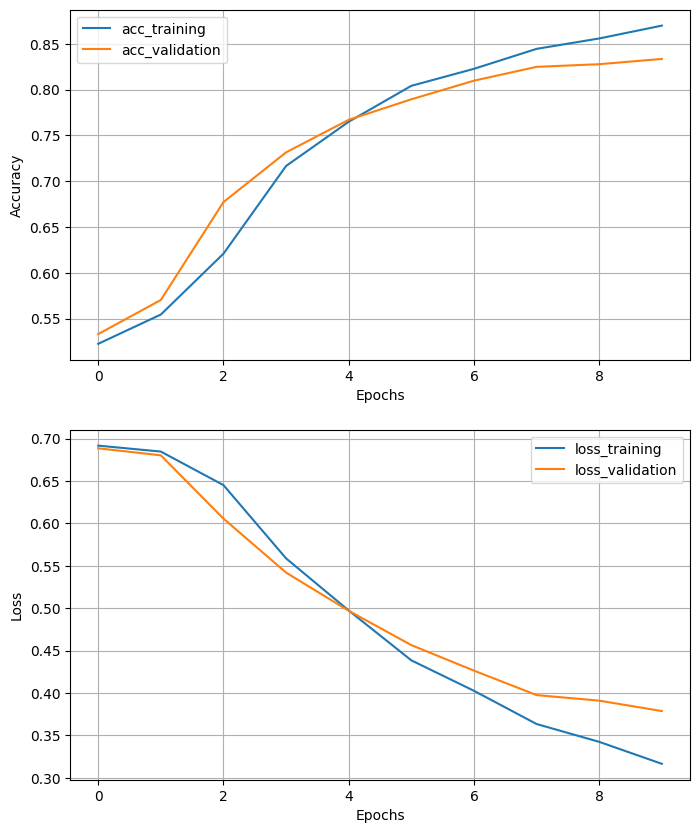

In [40]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):
    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(EPOCHS), acc_tr, label='acc_training')
    plt.plot(range(EPOCHS), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(EPOCHS), loss_tr, label='loss_training')
    plt.plot(range(EPOCHS), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)


In [41]:
def test(model, dataloader_test):
    model.eval()
    total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
    labels_from_pre_label = lambda x: 0. if x < 0.5 else 1.

    for idx, (label, text) in enumerate(dataloader_test):
        pre_label = model(text)
        loss += criterion(pre_label, label)
        pre_label = torch.tensor(list(map(labels_from_pre_label, pre_label))).to(model.device)
        total_acc_test += (pre_label == label).sum().item()
        total_count_test += label.size(0)
        n_batches_test += 1

    accuracy_test = total_acc_test / total_count_test
    loss_test = loss / n_batches_test

    print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
    print(f"Test Accuracy: {100 * accuracy_test:.4f}%")


In [42]:
test(model, dataloader_test)

Test Loss: 0.37552378 ---------- Test Accuracy: 83.9680%


# BiDirectional LSTM

In [44]:
vocab_length = len(vocab)
emb_dim = 10
hidden_size = 32
num_layers = 1
RNN_type = 'LSTM' #possible choices -> ['Simple RNN', 'LSTM', 'GRU']
bidirectional = True

EPOCHS = 15
lr = 3e-4

model = My_RNN(vocab_length=vocab_length, emb_dim=emb_dim, hidden_size=hidden_size,
               num_layers=num_layers, batch_size=batch_size, RNN_type=RNN_type,
               bidirectional=bidirectional).to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
summary(model)

Layer (type:depth-idx)                   Param #
My_RNN                                   --
├─Embedding: 1-1                         100,000
├─LSTM: 1-2                              11,264
├─Linear: 1-3                            65
Total params: 111,329
Trainable params: 111,329
Non-trainable params: 0

In [45]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, criterion, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 50.84%, Loss: 0.69308699 ---------------- Val_Acc: 53.65%, Val_Loss: 0.69188723
epoch: 2 -> Accuracy: 53.65%, Loss: 0.69103046 ---------------- Val_Acc: 55.33%, Val_Loss: 0.68993875
epoch: 3 -> Accuracy: 55.49%, Loss: 0.68766140 ---------------- Val_Acc: 56.69%, Val_Loss: 0.68352181
epoch: 4 -> Accuracy: 58.62%, Loss: 0.67299794 ---------------- Val_Acc: 57.89%, Val_Loss: 0.67276847
epoch: 5 -> Accuracy: 60.17%, Loss: 0.66244959 ---------------- Val_Acc: 57.23%, Val_Loss: 0.67393381
epoch: 6 -> Accuracy: 63.19%, Loss: 0.64622344 ---------------- Val_Acc: 63.61%, Val_Loss: 0.64156954
epoch: 7 -> Accuracy: 62.22%, Loss: 0.65047952 ---------------- Val_Acc: 62.46%, Val_Loss: 0.64666629
epoch: 8 -> Accuracy: 64.21%, Loss: 0.63630754 ---------------- Val_Acc: 63.35%, Val_Loss: 0.64288992
epoch: 9 -> Accuracy: 65.85%, Loss: 0.62493300 ---------------- Val_Acc: 64.76%, Val_Loss: 0.63008849
epoch: 10 -> Accuracy: 65.92%, Loss: 0.62198293 ---------------- Val_Acc: 65.32%, 

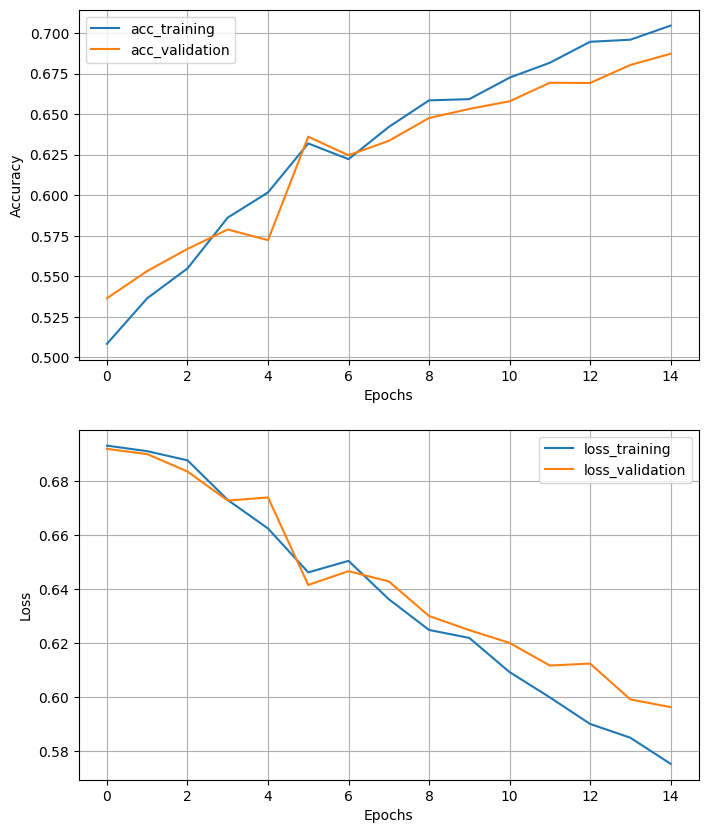

In [46]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [47]:
test(model, dataloader_test)

Test Loss: 0.59348708 ---------- Test Accuracy: 69.1840%


# Explore relations between words

Now I will explore the properties of the embeddings learned by the model. Each embedding encodes the meaning of a word inferring it from the way it is used in the dataset. One possible way to explore the meaning encoded in the embeddings is check whether analogies that we make between concepts are reflected also in the embeddings as geometric properties. In particular, I will compute the difference between the embeddings of two related words, thus encoding their relation in a vector. Then, I will compute the same measure between a few couples of vectors and check if the couple which has the most similar measure corresponds to words that have the same kind of relation as the first ones.

In [48]:
def word_embedder(word):
  word_high_dim = sent_padding(text_pipeline(word), maxlen=seq_len).to(device)
  word_low_dim_embedded = model.embedding(word_high_dim)[-1]
  return word_low_dim_embedded

EMB_VOCAB = {}
for word in vocab.get_itos():
  EMB_VOCAB[word] =  word_embedder(word)

In [49]:
def cosine_similarity(u, v):
    return torch.dot(u,v) / (torch.sqrt(torch.sum(u * u)) * torch.sqrt(torch.sum(v * v)))

def word_matcher(ref1, ref2, tgt3, candidates, EMB_VOCAB):
  max_thr = -np.inf
  e_ref1, e_ref2, e_tgt3 = EMB_VOCAB[ref1], EMB_VOCAB[ref2], EMB_VOCAB[tgt3]
  for w in candidates:
    e_w = EMB_VOCAB[w]
    sim = cosine_similarity(e_ref2 - e_ref1, e_w - e_tgt3)
    if sim > max_thr:
      result = w
      max_thr = sim
  return result

w1, w2, w3 = 'man', 'woman', 'king'
w4_cand = ['soldier', 'queen', 'prophet']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

w1, w2, w3 = 'germany', 'berlin', 'italy'
w4_cand = ['spain', 'rome', 'germany', 'france']
w4 = word_matcher(w1, w2, w3, w4_cand, EMB_VOCAB)
print(f'The relation between {w1} -> {w2} is like the realtion between {w3} -> {w4}')

The relation between man -> woman is like the realtion between king -> queen
The relation between germany -> berlin is like the realtion between italy -> spain


### Transformer

Let's now use a Transformer to perform the same task considered in the previous part.

The structure of the transformer is defined as follows:
*   A multi-head attention layer
*   Dropout operation (`dropout_att`)
*   Layer Normalization (`layernorm_att`)
*   A feedforward Neural Network, Sequential, and Dense layer
*   Dropout operation (`dropout_fnn`)
*   Layer Normalization (`layernorm_fnn`) that has in input the summation of the attention layer output and the feedforward NN output

In [50]:
new_seq_len = 200
train_dataset_trns = CustomDataset(train_data, seq_len=new_seq_len)
val_dataset_trns = CustomDataset(val_data, seq_len=new_seq_len)
test_dataset_trns = CustomDataset(test_data, seq_len=new_seq_len)

batch_size=256
dataloader_training_trns = DataLoader(train_dataset_trns, batch_size=batch_size, shuffle=True)
dataloader_validation_trns = DataLoader(val_dataset_trns, batch_size=batch_size)
dataloader_test_trns = DataLoader(test_dataset_trns, batch_size=batch_size)

In [51]:
class My_Transform(nn.Module):
  def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout, layer_norm_eps, device=device):
    super().__init__()
    self.device = device

    self.emb_en = Embedding(num_embeddings=len(vocab), embedding_dim=d_model)
    self.emb_de = Embedding(num_embeddings=2, embedding_dim=d_model)
    #2: because of binary classification

    self.transformer = Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                   num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward,
                                   dropout=dropout, layer_norm_eps=layer_norm_eps)

    self.linear = Linear(d_model, 1)#1: because of binary classification

  def forward(self, x, y):

    #x: (batch_size, seq_len) -> (256, 200)
    #y: (batch_size) -> (256)

    y = torch.roll(y, shifts=1, dims=0) #right shifted

    self.embedded_src = self.emb_en(x)
    #self.embedded_src: (batch_size, seq_len, d_model) -> (256, 200, 5)

    '''
    Transformer requires src_dim and trg_dim of (S, N, E)
    (S, N, E) -> (Seq_len, Batch_size, Embed_dim) -> (seq_len, batch_size, d_model)
        - self.embedded_src must be permuted
        - self.embedded_trg must be reshaped accordingly
    Transformer will produce an output of dim (T, N, E)
    (T, N, E) -> (Target_len, Batch_size, Embed_dim) -> (1, batch_size, d_model)
    '''

    self.embedded_src = self.embedded_src.permute(1, 0, 2)
    #self.embedded_src: (seq_len, batch_size, d_model) -> (200, 256, 5)
    self.embedded_trg = self.emb_de(y.unsqueeze(0).long())
    #self.embedded_trg: (seq_len:target_len, batch_size, d_model) -> (1, 256, 5)

    trns_out = self.transformer(self.embedded_src, self.embedded_trg)
    #trns_out: (target_len, batch_size, d_model) -> (1, 256, 5)

    out = self.linear(trns_out)
    #out: (1, 256, 1)

    return F.sigmoid(out.squeeze()) #(batch_size) -> (256) : Like y

In [52]:
d_model= 10
nhead= 2
num_encoder_layers= 2
num_decoder_layers= 2
dim_feedforward=128
dropout=0.1
layer_norm_eps=1e-5

EPOCHS = 10
lr = 1e-3

transformer = My_Transform(d_model, nhead, num_encoder_layers, num_decoder_layers,
                           dim_feedforward, dropout, layer_norm_eps).to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(transformer.parameters(), lr=lr)

summary(transformer)

Layer (type:depth-idx)                                                 Param #
My_Transform                                                           --
├─Embedding: 1-1                                                       100,000
├─Embedding: 1-2                                                       20
├─Transformer: 1-3                                                     --
│    └─TransformerEncoder: 2-1                                         --
│    │    └─ModuleList: 3-1                                            6,356
│    │    └─LayerNorm: 3-2                                             20
│    └─TransformerDecoder: 2-2                                         --
│    │    └─ModuleList: 3-3                                            7,276
│    │    └─LayerNorm: 3-4                                             20
├─Linear: 1-4                                                          11
Total params: 113,703
Trainable params: 113,703
Non-trainable params: 0

In [53]:
def train_trns(model, optimizer, dataloader_train, dataloader_val, epochs=EPOCHS):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):
    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (label, text) in enumerate(dataloader_train):

      optimizer.zero_grad()
      logits = model(text, label)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      labels_form_logits = lambda x: 0. if x < 0.5 else 1.
      logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
      total_acc_train += (logits == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)

    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (label, text) in enumerate(dataloader_val):

            logits = model(text, label)
            loss = criterion(logits, label)
            total_loss_val += loss
            logits = torch.tensor(list(map(labels_form_logits, logits))).to(model.device)
            total_acc_val += (logits == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val)
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [54]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train_trns(transformer, optimizer, dataloader_training_trns, dataloader_validation_trns, epochs=EPOCHS)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 53.32%, Loss: 0.68917835 ---------------- Val_Acc: 54.29%, Val_Loss: 0.68213105
epoch: 2 -> Accuracy: 65.97%, Loss: 0.61764127 ---------------- Val_Acc: 70.89%, Val_Loss: 0.57099783
epoch: 3 -> Accuracy: 73.79%, Loss: 0.53309298 ---------------- Val_Acc: 75.20%, Val_Loss: 0.51276696
epoch: 4 -> Accuracy: 78.82%, Loss: 0.46046472 ---------------- Val_Acc: 79.62%, Val_Loss: 0.44693616
epoch: 5 -> Accuracy: 81.71%, Loss: 0.41459784 ---------------- Val_Acc: 81.07%, Val_Loss: 0.41716602
epoch: 6 -> Accuracy: 83.21%, Loss: 0.38312355 ---------------- Val_Acc: 81.97%, Val_Loss: 0.39834180
epoch: 7 -> Accuracy: 84.45%, Loss: 0.35842809 ---------------- Val_Acc: 82.71%, Val_Loss: 0.38040471
epoch: 8 -> Accuracy: 85.66%, Loss: 0.33557788 ---------------- Val_Acc: 83.54%, Val_Loss: 0.36955494
epoch: 9 -> Accuracy: 86.47%, Loss: 0.32031241 ---------------- Val_Acc: 83.78%, Val_Loss: 0.36993840
epoch: 10 -> Accuracy: 87.39%, Loss: 0.30493584 ---------------- Val_Acc: 82.71%, 

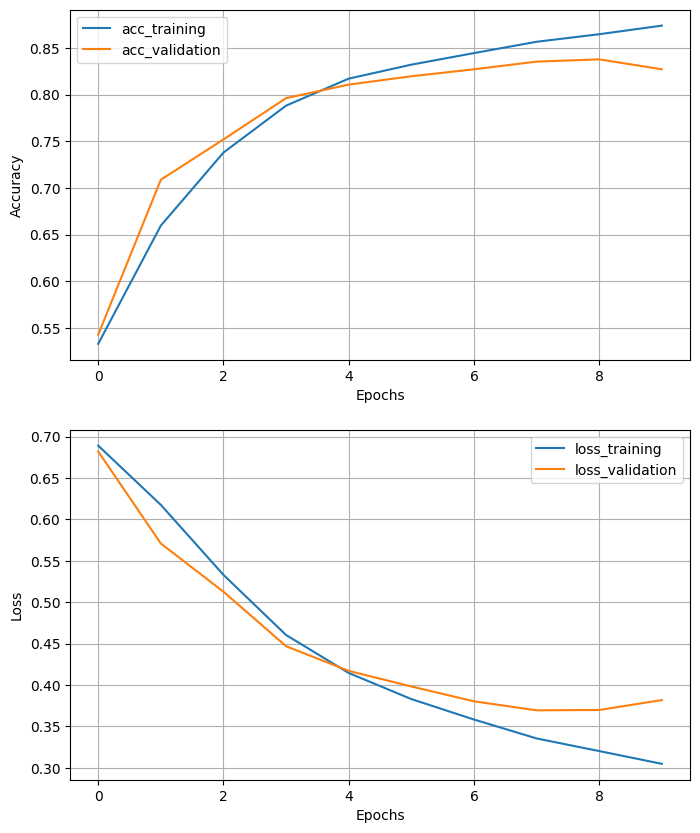

In [55]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [56]:
def test_trns(model, dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (label, text) in enumerate(dataloader_test):
      pre_label = model(text, label)
      loss += criterion(pre_label, label)
      labels_form_pre_label = lambda x: 0. if x < 0.5 else 1.
      pre_label = torch.tensor(list(map(labels_form_pre_label, pre_label))).to(model.device)
      total_acc_test += (pre_label == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [57]:
gc.collect()
test_trns(transformer, dataloader_test_trns)

Test Loss: 0.38335967 ---------- Test Accuracy: 82.6480%
